In [4]:
"""Create parameters.py from a .inp and load it"""
# This cell is facultative, you can use an existing parameters.py

# Directory for .inp file:
path = 'INP file examples\\chemkin_AR_HE.inp'

# import libraries:
import importlib   # for reloading your own files
# my own files:
import inp_data_extractor as inp
importlib.reload(inp)

# create parameters.py
inp.extract(path)

# load parameters.py
import parameters as par
importlib.reload(par)
print(par.model)

Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'O' is not in data.py: 0.0 is used
Note, lambda value for specie 'OH' is not in data.py: 0.0 is used
Note, lambda value for specie 'HO2' is not in data.py: 0.0 is used
Note, lambda value for specie 'OHEX' is not in data.py: 0.0 is used
Warning, third body 'CO' is not in species in line 65 ('H2/2.5/ O2/1/ H2O/12/ CO/1.9/ CO2/3.8/ HE/0.83/ AR/1/') in reaction '2H+M=H2+M'
Warning, third body 'CO2' is not in species in line 65 ('H2/2.5/ O2/1/ H2O/12/ CO/1.9/ CO2/3.8/ HE/0.83/ AR/1/') in reaction '2H+M=H2+M'
Warning, third body 'CO' is not in species in line 67 ('H2/2.5/ H2O/12/ AR/0.83/ CO/1.9/ CO2/3.8/ HE/0.83/') in reaction '2O+M=O2+M'
Warning, third body 'CO2' is not in species in line 67 ('H2/2.5/ H2O/12/ AR/0.83/ CO/1.9/ CO2/3.8/ HE/0.83/') in reaction '2O+M=O2+M'
Warning, third body 'CO' is not in species in line 69 ('H2/2.5/ O2/1/ H2O/12/ AR/0.75/ CO/1.5/ CO2/2/ HE/0.75/') in reaction 'O+H

In [5]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made

# my own file:
import pattern_search as ps    # full bubble model
importlib.reload(ps)   # reload changes you made

to_optimize = 'energy'   # key in data from de.get_data()

model: chemkin_AR_HE
model: chemkin_AR_HE
model: chemkin_AR_HE


In [7]:
"""Control parameter ranges"""
# Range or a single value for most control parameters

ranges = dict(
    # Equilibrium radius [um --> m]
    R_E = [0.5e-6, 20e-6],
    # R_star / R_E [-]
    ratio = [1.5, 25.0],
    # Ambient pressure [Pa]
    P_inf = [1.0e5, 50.0e5],
    # Accommodation coeff. for evaporation [-]
    alfa_M = [0.05, 0.35],
    # Ambient temperature [°C --> K]
    T_inf = [T+273.15 for T in [5.0, 50.0]],
    # Surface tension modifier [-]
    surfactant = [0.5, 1.0]
)

In [8]:
"""Pattern search, multithread"""

searches = 100    # number os total searches

best_output = 1e30
total_point_num = 0
num = 0
to_plot = []
last_points = []
start = time.time()
file = ps.de.Make_dir('test 1')

kwargs_list = [dict(
    ranges=ranges,
    to_optimize=to_optimize,
    start_point=ps.rand_point(ranges, gases=[ps.de.par.index['AR']], fractions=[1.0]),
    max_steps=100,
    first_step=0.1,
    min_step=0.02,
    decay=0.6,
    t_int=np.array([0.0, 1.0]),
    LSODA_timeout=30,
    Radau_timeout=300,
    ) for i in range(searches)]

with Pool(processes=cpu_count(), maxtasksperchild=10) as pool:
    results = pool.imap_unordered(ps.search, kwargs_list)

    for result in results:
        datas, best_values, elapsed, step_num, point_num = result
        total_point_num += point_num
        num += 1
        to_plot.append(best_values)
        last_points.append(datas[-1])
        if best_values[-1] < best_output:
            best_output = best_values[-1]

        # save points
        file.new_file()
        for data in datas:
            file.write_line(data)
        file.close()
        
        # print stuff:
        print(f'{num}/{searches}: Total {step_num} steps and {point_num} points, finished in {elapsed: .2f} [s]   ({(elapsed / point_num): .2f} [s/run]).   '+
              f'Final {to_optimize}: {best_values[-1]: .1f} (best: {best_output: .1f})')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {(elapsed / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / total_point_num): .2f} [s/run])')

Folder already exists with 0 csv in it
1/100: Total 33 steps and 337 points, finished in  397.11 [s]   ( 1.18 [s/run]).   Final energy:  7408.6 (best:  7408.6)
2/100: Total 33 steps and 312 points, finished in  437.29 [s]   ( 1.40 [s/run]).   Final energy:  6854.8 (best:  6854.8)
3/100: Total 25 steps and 229 points, finished in  496.68 [s]   ( 2.17 [s/run]).   Final energy:  5551.1 (best:  5551.1)
4/100: Total 17 steps and 148 points, finished in  616.81 [s]   ( 4.17 [s/run]).   Final energy:  9768.2 (best:  5551.1)
5/100: Total 37 steps and 380 points, finished in  734.35 [s]   ( 1.93 [s/run]).   Final energy:  5701.5 (best:  5551.1)
6/100: Total 41 steps and 371 points, finished in  804.06 [s]   ( 2.17 [s/run]).   Final energy:  5626.6 (best:  5551.1)
7/100: Total 33 steps and 302 points, finished in  917.71 [s]   ( 3.04 [s/run]).   Final energy:  6662.2 (best:  5551.1)
8/100: Total 25 steps and 245 points, finished in  491.14 [s]   ( 2.00 [s/run]).   Final energy:  7725.8 (best:  5

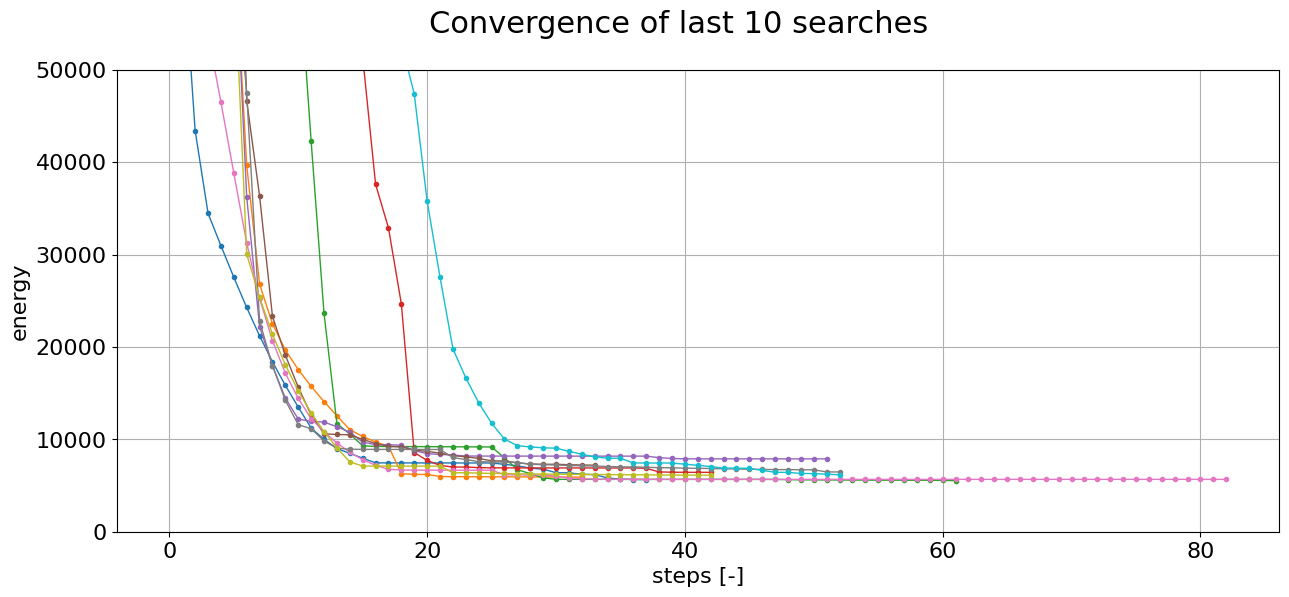

In [14]:
"""Plot convergence of last searches"""

plt.rcParams.update({'font.size': 16})
if len(to_plot) > 10:
    to_plot2 = to_plot[-10:]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Convergence of last 10 searches', fontsize=22)
ax.set_ylabel(f'{to_optimize}')
ax.set_ylim(0.0, 0.5e5)
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()

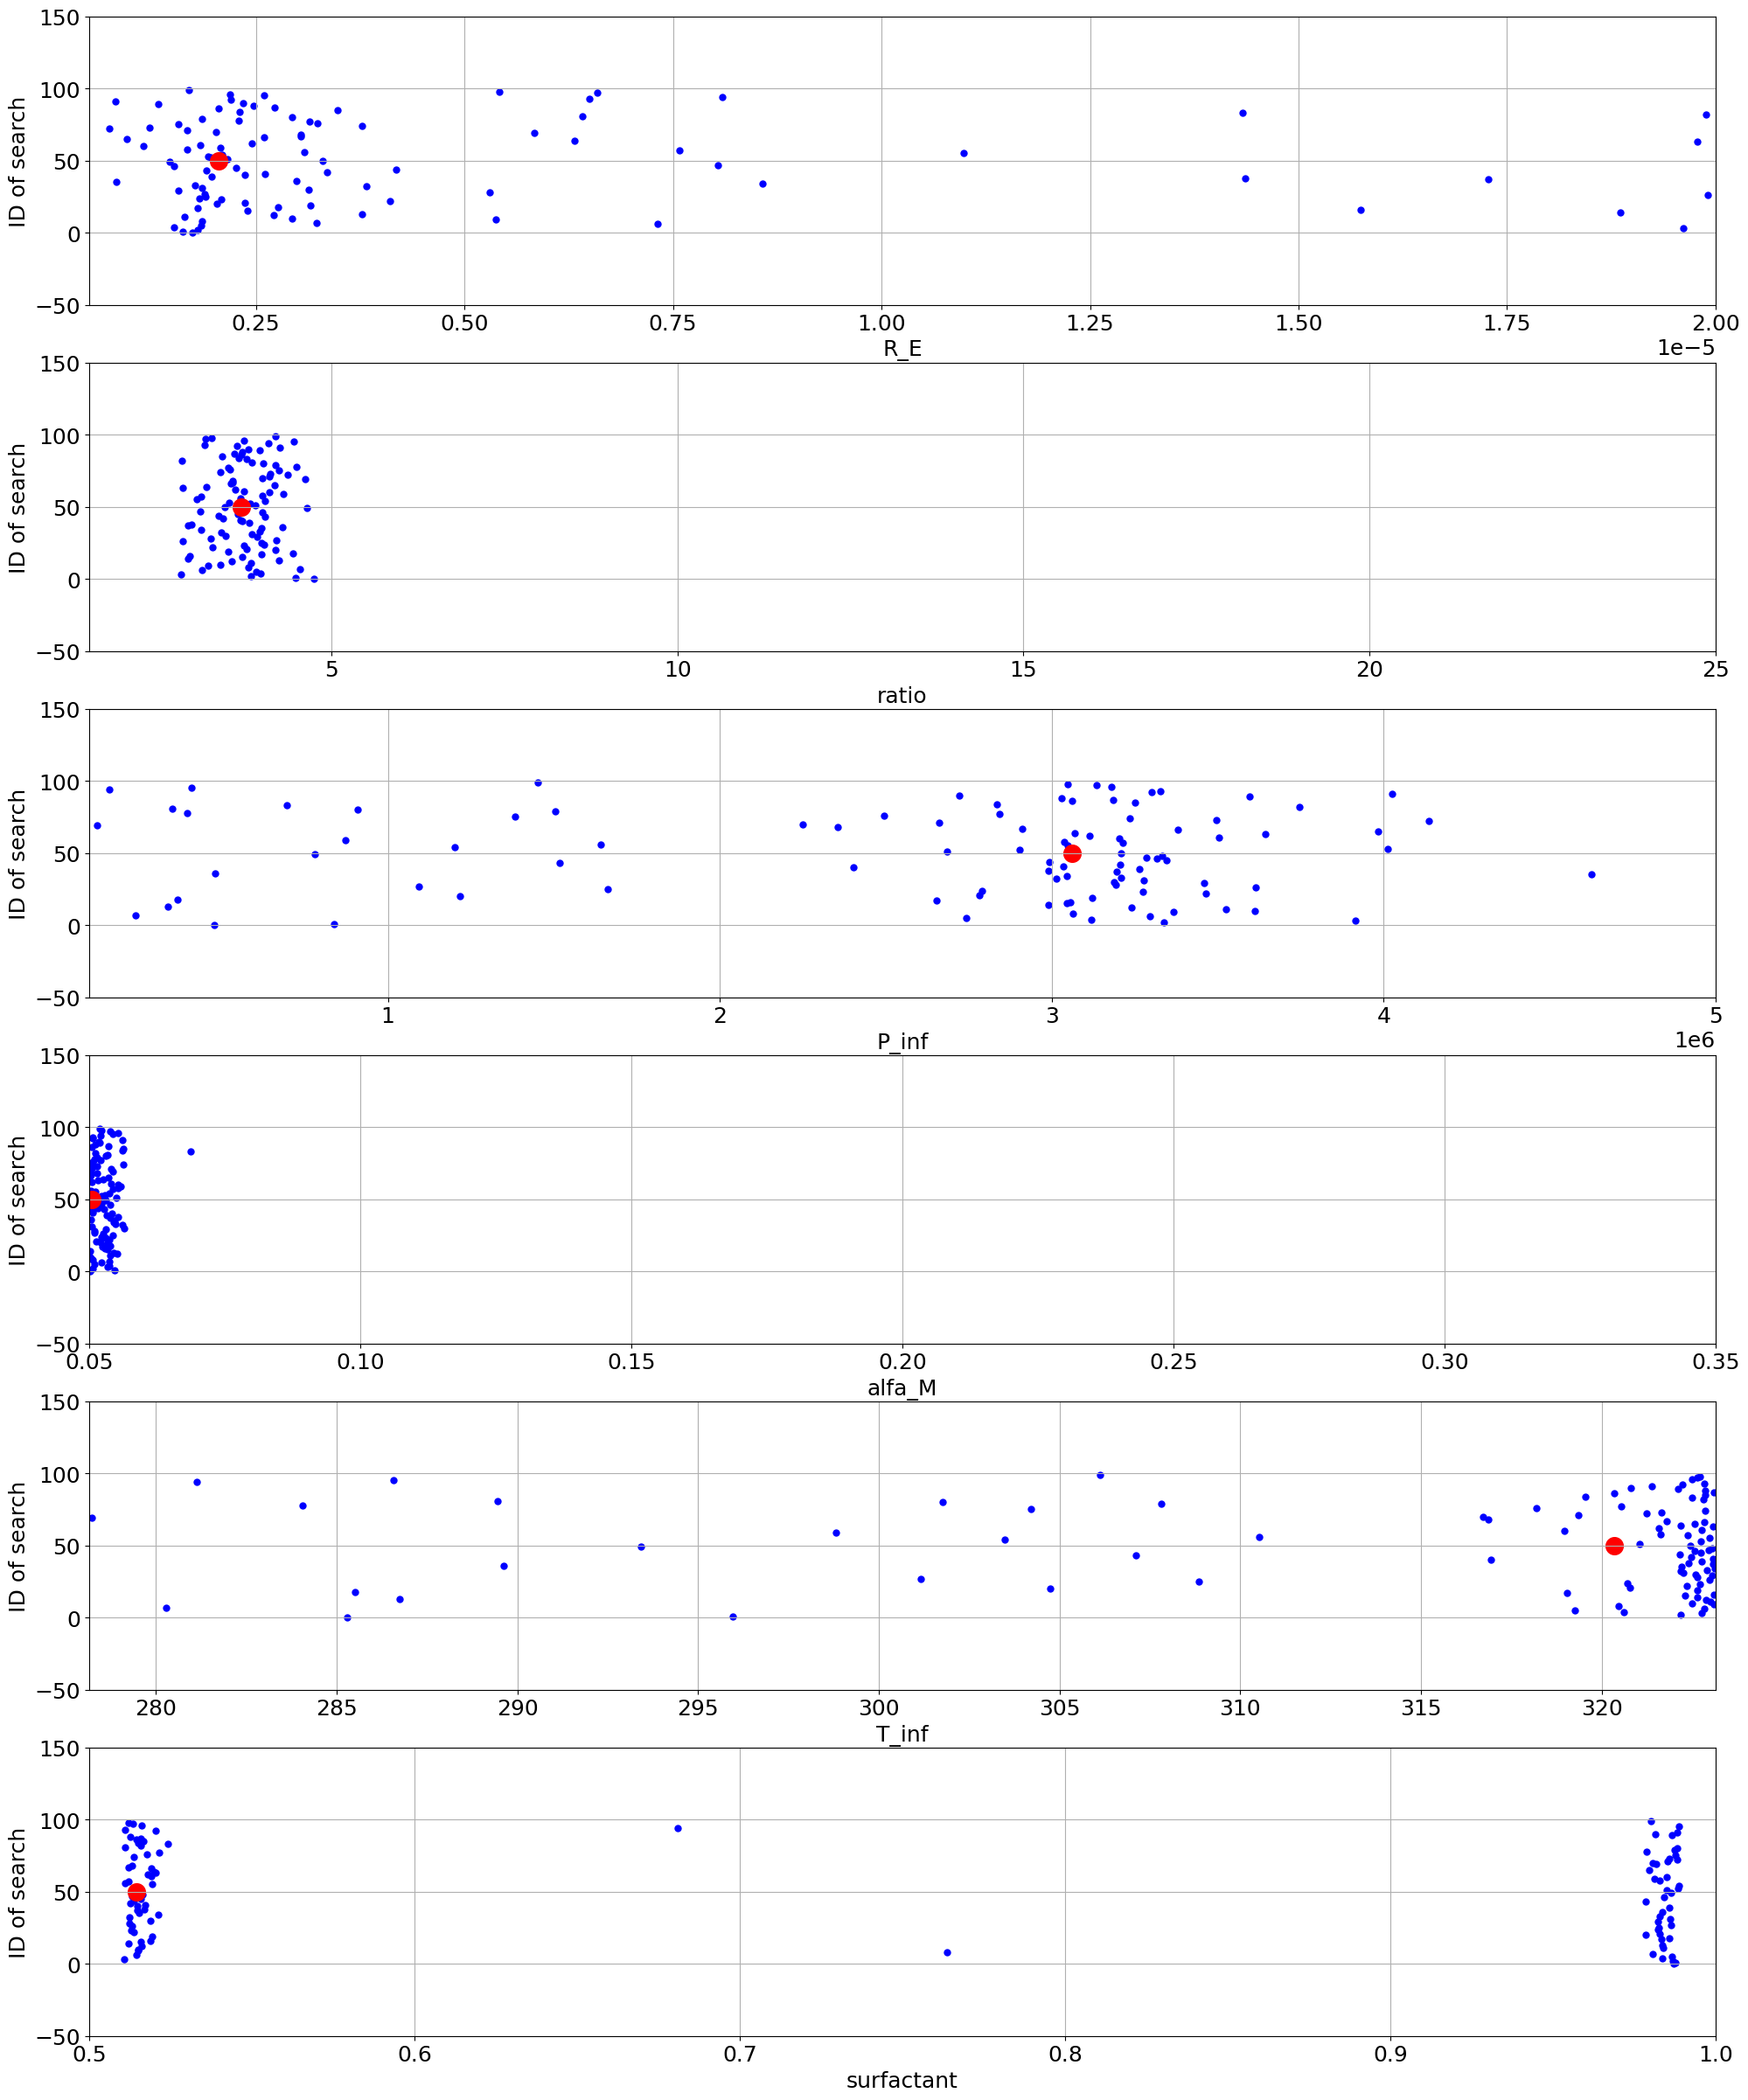

In [61]:
"""Plot the distribution of the optimums"""

plt.rcParams.update({'font.size': 18})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points]
    y = [i for i, last_point in enumerate(last_points)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=25, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.5*n, 1.5*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')